# Behavioral Analysis of the Transfer Checkpoint

This notebook will inspect the checkpoint trained from the swapped decoder from the track-mjx checkpoint for task driven down stream task. Specifically, I will make the following renderings to highlights the transfer performance.

1. action through time
2. intention clustering
3. gait pattern graph for limbs
4. force of the gait

I will also do several rollout, with different bowl difficulties, potentially also with a flat arena.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import logging
from tqdm import tqdm
# Send logging outputs to stdout (comment this out if preferred)
# logger = logging.getLogger()
# logger.setLevel(logging.INFO)

os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# plotting related
from tqdm import tqdm
import numpy as np
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
import multiprocessing as mp
import functools
from track_mjx.agent import checkpointing
from vnl_mjx.tasks.rodent import flat_arena, bowl_escape
import mediapy as media
from orbax import checkpoint as ocp
from sklearn.decomposition import PCA
import seaborn as sns
import sklearn
import mujoco
from pathlib import Path
from mujoco import mjx

import jax
# Enable persistent compilation cache.
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


initialize your environment, also modify your env here

In [3]:
# Load config from checkpoint
# replace with your checkpoint path
checkpoints_dir = Path("/root/vast/scott-yang/vnl-mjx/model_checkpoints")

transfer_and_freeze = checkpoints_dir / "250701_203400"
transfer_not_freeze = checkpoints_dir / "250701_203433"
transfer_005_lr = checkpoints_dir / "250702_035047"
transfer_05_lr = checkpoints_dir / "250702_035205"
transfer_01_lr = checkpoints_dir / "250702_040055"

ckpts_paths = {
    "transfer_and_freeze": transfer_and_freeze,
    "transfer_not_freeze": transfer_not_freeze,
    "transfer_005_lr": transfer_005_lr,
    "transfer_05_lr": transfer_05_lr,
    "transfer_01_lr": transfer_01_lr,
}

ckpt = checkpointing.load_checkpoint_for_eval(transfer_and_freeze, step=98)
cfg = ckpt["cfg"]
cfg["env_config"]["env_args"]["bowl_vsize"] = 0.4
env = bowl_escape.BowlEscape(config_overrides=cfg["env_config"]["env_args"])
jit_reset, jit_step = jax.jit(env.reset), jax.jit(env.step)

Loading checkpoint from /root/vast/scott-yang/vnl-mjx/model_checkpoints/250701_203400 at step 98
Initial position: 0.0, 0.0, 0.009999999776482582


In [4]:
inference_fn = checkpointing.load_inference_fn(cfg, ckpt["policy"])
jit_inference_fn = jax.jit(inference_fn)

some rendering helper functions

In [5]:
# some rendering related code
from typing import List


def visualize_features(
    features, window_size, title, frame, feature_mask: List[int] | None = None
):
    """
    Render one frame of the sliding window plot.

    For frame indices less than window_size, it displays the data from index 0 to current index,
    but fixes the x-axis from 0 to window_size. For later frames, the most recent window_size time
    steps are displayed. A red vertical line indicates the current time index.

    Args:
        features: A 2D numpy array of shape (feature_dim, time_dim) representing the features.
        window_size: The size of the sliding window.
        frame: The current frame index.

    Returns:
        rgb_array: A numpy array of shape (480, 640, 3) representing the rendered image.
    """
    if type(features) is not np.ndarray:
        features = np.array(features)
    if feature_mask is not None:
        features = features[feature_mask[0] : feature_mask[1], :]
    # Compute global min and max to keep colormap consistent
    global_vmin = float(features.min())
    global_vmax = float(features.max())

    current_idx = frame + 1  # current time step (1-indexed)

    # Create the figure with fixed dimensions: 6.4x4.8 inches at dpi=100 gives 640x480 pixels.
    fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=100)
    plt.tight_layout()
    canvas = FigureCanvas(fig)

    if current_idx < window_size:
        # For early frames, plot data from 0 to current_idx.
        window_data = features[:, :current_idx]  # shape: (147, current_idx)
        # Set extent so the data covers [0, current_idx] in x,
        # but later we force the x-axis to show 0 to window_size.
        extent = [0, current_idx, 0, features.shape[0]]
        ax.imshow(
            window_data,
            aspect="auto",
            interpolation="none",
            origin="lower",
            extent=extent,
            vmin=global_vmin,
            vmax=global_vmax,
        )
        # Fix x-axis to [0, window_size]
        ax.set_xlim(0, window_size)
        # Draw red vertical line at the current index
        ax.axvline(x=current_idx, color="red", linewidth=2)
    else:
        # For later frames, display the most recent window_size time steps.
        window_data = features[
            :, current_idx - window_size : current_idx
        ]  # shape: (147, window_size)
        extent = [current_idx - window_size, current_idx, 0, features.shape[0]]
        ax.imshow(
            window_data,
            aspect="auto",
            interpolation="none",
            origin="lower",
            extent=extent,
            vmin=global_vmin,
            vmax=global_vmax,
        )
        # Even here, we fix the view from 0 to window_size (the window length).
        ax.set_xlim(current_idx - window_size, current_idx)

        ax.axvline(x=current_idx, color="red", linewidth=2)
    # ax.yaxis.set_visible(False)
    # This hides the entire y-axis including ticks and labels
    ax.set_title(title)
    # Render the figure and convert to a NumPy RGB array using the proper canvas method.
    canvas.draw()
    s, (width, height) = canvas.print_to_buffer()
    image = Image.frombytes("RGBA", (width, height), s)
    rgb_array = np.array(image.convert("RGB"))
    plt.close(fig)
    return rgb_array


##### PCA rendering related


def plot_pca_intention(
    idx,
    episode_start,
    pca_projections: np.ndarray,
    feature_name: str,
    pca: PCA,
    n_components: int = 4,
    terminated=False,
):
    """
    plot pca intention progression of the episode
    Args:
        idx: the current timestep
        episode_start: the start timestep of the episode
        pca_projections: the pca projection of the episode, shape (timestep, n_components)
        clip_idx: the clip index
        feature_name: the feature name
        n_components: the number of pca components to plot
        ylim: the y-axis limit
        terminated: whether the episode is terminated

    """
    max_y = np.max(list(pca_projections[:, :n_components]))
    min_y = np.min(list(pca_projections[:, :n_components]))
    y_lim = (min_y - 0.2, max_y + 0.2)
    window_size = 530
    idx_in_this_episode = idx - episode_start  # the current timestep in this episode
    plt.figure(figsize=(9.6, 4.8))
    for pc_ind in range(n_components):
        # Plot the PCA projection of the episode
        plt.plot(
            pca_projections[episode_start:idx, pc_ind],
            label=f"PC {pc_ind + 1} ({pca.explained_variance_ratio_[pc_ind]*100:.1f}%)",
        )
        plt.scatter(idx - episode_start, pca_projections[idx - 1, pc_ind])
    if terminated:
        # Mark the episode termination
        plt.axvline(x=idx - episode_start, color="r", linestyle="-")
        plt.text(
            idx - episode_start - 8,  # Adjust the x-offset as needed
            sum(y_lim) / 2,  # Adjust the y-position as needed
            "Episode Terminated",
            color="r",
            rotation=90,
        )  # Rotate the text vertically
    if idx_in_this_episode <= window_size:
        plt.xlim(0, window_size)
    else:
        plt.xlim(
            idx_in_this_episode - window_size, idx_in_this_episode
        )  # dynamically move xlim as time progress
    sns.despine()
    plt.ylim(*y_lim)
    plt.legend(loc="upper right")
    plt.xlabel("Timestep")
    plt.title(f"PCA {feature_name} Progression")  # TODO make it configurabl
    # Get the current figure
    fig = plt.gcf()
    # Create a canvas for rendering
    canvas = FigureCanvas(fig)
    # Render the canvas to a buffer
    canvas.draw()
    s, (width, height) = canvas.print_to_buffer()
    # Convert the buffer to a PIL Image
    image = Image.frombytes("RGBA", (width, height), s)
    rgb_array = np.array(image.convert("RGB"))
    return rgb_array

In [ ]:
ckpt_path = "/root/vast/scott-yang/vnl-mjx/model_checkpoints/250702_040055"
ckpt = checkpointing.load_checkpoint_for_eval(ckpt_path)
# once you compile the environment, you can easily swap the checkpoint
# and do the rollout and renderings
inference_fn = checkpointing.load_inference_fn(cfg, ckpt["policy"])
jit_inference_fn = jax.jit(inference_fn)

### Generate a rollout

In [6]:
rng = jax.random.PRNGKey(2)

rng, reset_rng = jax.random.split(rng)
state = jit_reset(reset_rng)
rollout = []
network_info = []
for i in tqdm(range(2000)):
    act_rng, rng = jax.random.split(rng)
    ctrl, info = jit_inference_fn(state.obs, act_rng)
    network_info.append(info)
    state = jit_step(state, ctrl)
    rollout.append(state)

actions = np.array([r.data.ctrl for r in rollout]).T
intentions = np.array([i["activations"]["intention"] for i in network_info]).T
actions.shape, intentions.shape

/root/miniforge3/envs/track-mjx/lib/python3.11/site-packages/jax/_src/abstract_arrays.py:111: RuntimeWarning: overflow encountered in cast
  return literals.LiteralArray(np.asarray(x, dtype), weak_type=False)
100%|██████████| 2000/2000 [02:25<00:00, 13.70it/s] 


((38, 2000), (16, 2000))

QC of the rollout

In [8]:
import mujoco

render_every = 1
fps = 1.0 / env.dt / render_every
traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

frames = env.render(
    traj,
    camera="close_profile-rodent",
    scene_option=scene_option,
    height=480 * 4,
    width=640 * 4,
)

# media.show_video(frames, fps=fps, loop=False)
media.write_video("./transfer_freeze.mp4", frames)

 32%|███▏      | 642/2000 [00:06<00:12, 107.37it/s]

100%|██████████| 2000/2000 [00:19<00:00, 102.21it/s]


## Rendering

In [9]:
# Parameters
actions = np.array(actions)
window_size = 300
total_time = actions.shape[1]  # should be 499
title = "Actions"
# Use multiprocessing to parallelize the rendering.
f = functools.partial(visualize_features, actions, window_size, title)
with mp.Pool(processes=mp.cpu_count()) as pool:
    frames_plt_1 = pool.map(f, list(range(total_time)))

/root/miniforge3/envs/track-mjx/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
import mujoco

render_every = 1
fps = 1.0 / env.dt / render_every
traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

frames = env.render(
    traj,
    camera="close_profile-rodent",
    scene_option=scene_option,
    height=480,
    width=640,
)

In [ ]:
save_videos = False
# rendering the frames and save to disk
combined_video = np.concatenate((frames, frames_plt_1), axis=2)
media.show_video(combined_video, fps=fps, loop=False)
if save_videos:
    media.write_video(
        f"videos/flat_escape_action_plot.mp4", combined_video, fps=fps, qp=18
    )

In [ ]:
# Parameters
intentions = np.array(intentions)
window_size = 300
total_time = intentions.shape[1]  # should be 499
title = "Intentions Vectors"
# Use multiprocessing to parallelize the rendering.
f = functools.partial(visualize_features, intentions, window_size, title)
with mp.Pool(processes=mp.cpu_count()) as pool:
    frames_plt_intention = pool.map(f, list(range(total_time)))

In [ ]:
save_videos = False
# rendering the frames and save to disk
combined_video = np.concatenate((frames, frames_plt_intention), axis=2)
media.show_video(combined_video, fps=fps, loop=False)
if save_videos:
    media.write_video(
        f"videos/flat_bowl_escape_intention_plot.mp4", combined_video, fps=fps, qp=18
    )

In [10]:
pca = PCA()
pca.fit(intentions.T)
pca_embedded = pca.transform(intentions.T)
pca_embedded.shape

(2000, 16)

In [11]:
# explained variance ratio
pca.explained_variance_ratio_.round(2)

array([0.82, 0.1 , 0.05, 0.02, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  ], dtype=float32)

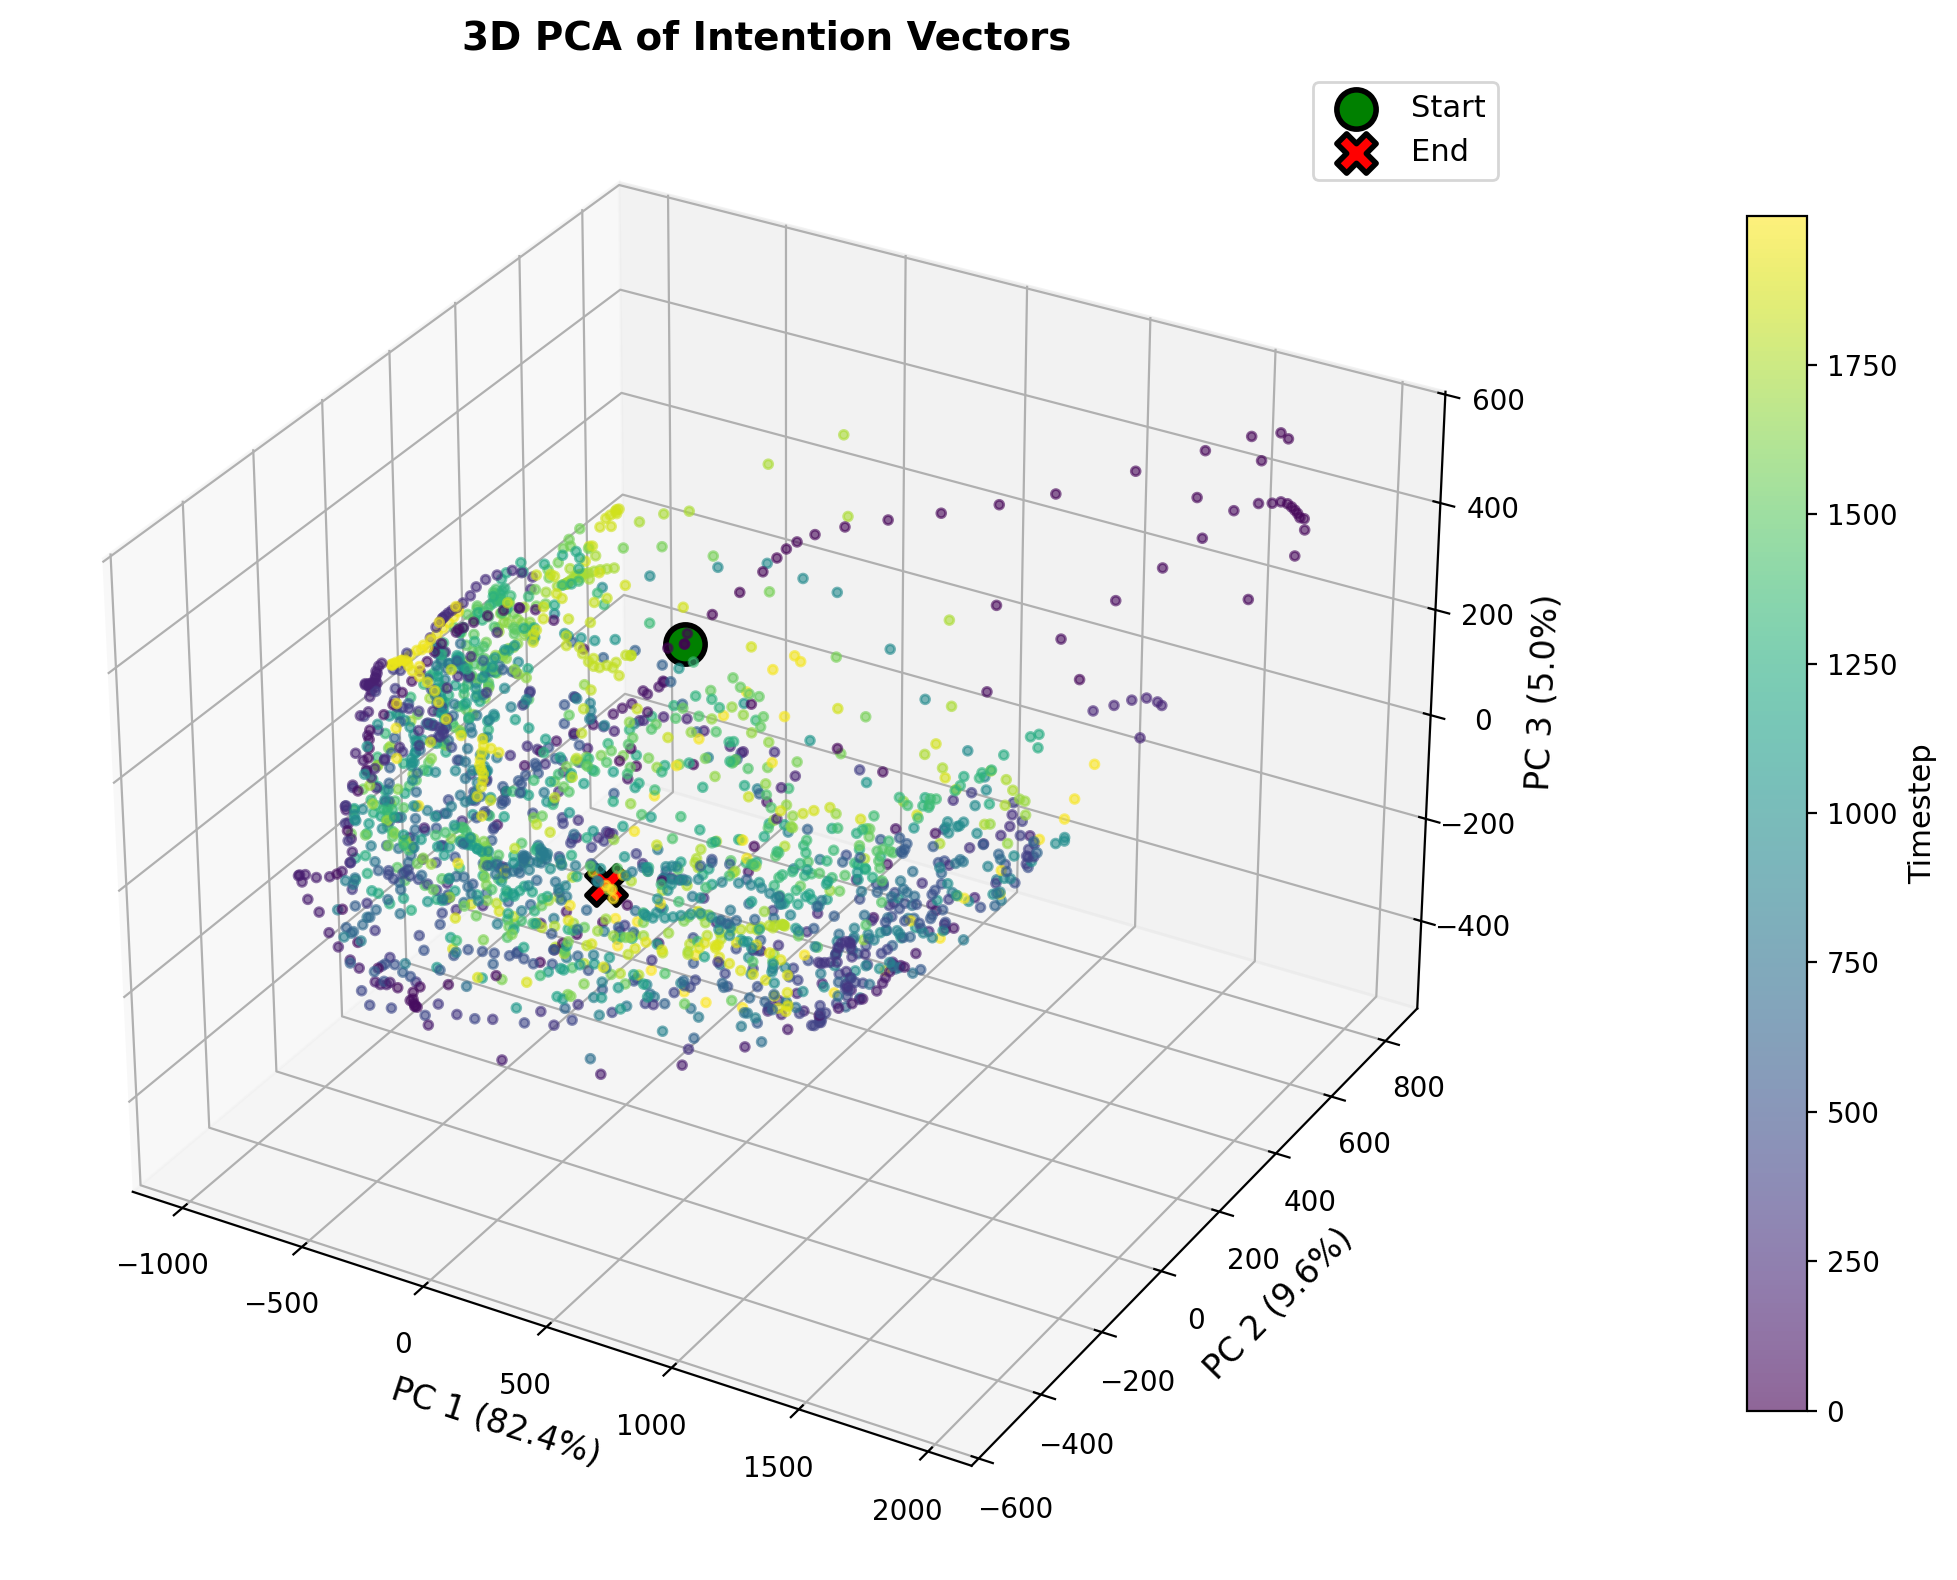

In [13]:
# 3D PCA visualization
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the trajectory in 3D PCA space
# Color by time to show progression
time_colors = np.arange(len(pca_embedded))
scatter = ax.scatter(
    pca_embedded[:, 0],
    pca_embedded[:, 1],
    pca_embedded[:, 2],
    c=time_colors,
    cmap="viridis",
    alpha=0.6,
    s=10,
)

# Mark start and end points
ax.scatter(
    pca_embedded[0, 0],
    pca_embedded[0, 1],
    pca_embedded[0, 2],
    c="green",
    s=200,
    marker="o",
    label="Start",
    edgecolors="black",
    linewidths=2,
)
ax.scatter(
    pca_embedded[-1, 0],
    pca_embedded[-1, 1],
    pca_embedded[-1, 2],
    c="red",
    s=200,
    marker="X",
    label="End",
    edgecolors="black",
    linewidths=2,
)

# Labels with variance explained
ax.set_xlabel(f"PC 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=12)
ax.set_ylabel(f"PC 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize=12)
ax.set_zlabel(f"PC 3 ({pca.explained_variance_ratio_[2]*100:.1f}%)", fontsize=12)
ax.set_title("3D PCA of Intention Vectors", fontsize=14, fontweight="bold")

# Add colorbar to show time progression
cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label("Timestep", fontsize=11)

ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# 3D PCA animation with trailing effect
from mpl_toolkits.mplot3d import Axes3D


def plot_3d_pca_frame(frame_idx, pca_embedded, pca, trail_length=50):
    """
    Render a single frame of the 3D PCA animation with trailing effect.

    Args:
        frame_idx: Current timestep to render
        pca_embedded: PCA projections (timesteps x components)
        pca: Fitted PCA object
        trail_length: Number of previous timesteps to show in the trail
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Plot all points as gray background to show overall structure
    ax.scatter(
        pca_embedded[:, 0],
        pca_embedded[:, 1],
        pca_embedded[:, 2],
        c="gray",
        alpha=0.15,
        s=5,
        zorder=1,
    )

    # Get Set2 color palette from seaborn
    set2_colors = sns.color_palette("Set2", 8)
    trail_color = set2_colors[0]  # Use first color from Set2

    # Calculate trail start index
    trail_start = max(0, frame_idx - trail_length)

    # Plot the trailing points with decreasing alpha
    if frame_idx > 0:
        trail_points = pca_embedded[trail_start : frame_idx + 1]
        n_trail = len(trail_points)

        # Create alpha values that fade from low to high (older to newer)
        alphas = np.linspace(0.1, 0.8, n_trail)

        # Plot trail as connected line segments with varying alpha
        for i in range(n_trail - 1):
            ax.plot(
                trail_points[i : i + 2, 0],
                trail_points[i : i + 2, 1],
                trail_points[i : i + 2, 2],
                color=trail_color,
                alpha=alphas[i],
                linewidth=2,
                zorder=5,
            )

    # Plot current point as a larger dot
    ax.scatter(
        pca_embedded[frame_idx, 0],
        pca_embedded[frame_idx, 1],
        pca_embedded[frame_idx, 2],
        c=[set2_colors[1]],  # Use second color from Set2 for current point
        s=100,
        marker="o",
        edgecolors="black",
        linewidths=2,
        zorder=10,
    )

    # Mark start point (only visible early in animation)
    if frame_idx < trail_length:
        ax.scatter(
            pca_embedded[0, 0],
            pca_embedded[0, 1],
            pca_embedded[0, 2],
            c=[set2_colors[2]],  # Use third color from Set2 for start
            s=150,
            marker="o",
            label="Start",
            edgecolors="black",
            linewidths=2,
            alpha=0.5,
            zorder=8,
        )

    # Set consistent axis limits based on all data
    margin = 0.1
    for axis, idx in [("x", 0), ("y", 1), ("z", 2)]:
        min_val = pca_embedded[:, idx].min()
        max_val = pca_embedded[:, idx].max()
        range_val = max_val - min_val
        if axis == "x":
            ax.set_xlim(min_val - margin * range_val, max_val + margin * range_val)
        elif axis == "y":
            ax.set_ylim(min_val - margin * range_val, max_val + margin * range_val)
        else:
            ax.set_zlim(min_val - margin * range_val, max_val + margin * range_val)

    # Labels with variance explained
    ax.set_xlabel(f"PC 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=12)
    ax.set_ylabel(f"PC 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize=12)
    ax.set_zlabel(f"PC 3 ({pca.explained_variance_ratio_[2]*100:.1f}%)", fontsize=12)
    ax.set_title(
        f"3D PCA Trajectory - Timestep {frame_idx}/{len(pca_embedded)-1}",
        fontsize=14,
        fontweight="bold",
    )

    if frame_idx < trail_length:
        ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()

    # Render to RGB array
    canvas = FigureCanvas(fig)
    canvas.draw()
    s, (width, height) = canvas.print_to_buffer()
    image = Image.frombytes("RGBA", (width, height), s)
    rgb_array = np.array(image.convert("RGB"))
    plt.close(fig)

    return rgb_array


# Generate frames using multiprocessing
print("Generating 3D PCA animation frames...")
orig_backend = matplotlib.get_backend()
matplotlib.use("Agg")  # Switch to headless mode

worker = functools.partial(
    plot_3d_pca_frame,
    pca_embedded=pca_embedded,
    pca=pca,
    trail_length=100,  # Adjust trail length as needed
)

with mp.Pool(processes=mp.cpu_count()) as pool:
    frames_3d_pca = pool.map(worker, list(range(len(pca_embedded))))

matplotlib.use(orig_backend)  # Restore backend
print(f"Generated {len(frames_3d_pca)} frames")

Generating 3D PCA animation frames...


/root/miniforge3/envs/track-mjx/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/miniforge3/envs/track-mjx/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/root/miniforge3/envs/track-mjx/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Generated 2000 frames


In [ ]:
# Display and save the 3D PCA animation
save_videos = True

# Show the animation
media.show_video(frames_3d_pca, fps=fps, loop=False)

if save_videos:
    media.write_video(
        "videos/3d_pca_intention_trajectory.mp4", frames_3d_pca, fps=fps, qp=18
    )

In [ ]:
# Parameters
intentions = pca_embedded.T[:3, :]
window_size = 300
total_time = intentions.shape[1]  # should be 499
title = "Intentions Vectors"
# Use multiprocessing to parallelize the rendering.
f = functools.partial(visualize_features, intentions, window_size, title)
with mp.Pool(processes=mp.cpu_count()) as pool:
    frames_plt_intention = pool.map(f, list(range(total_time)))

In [ ]:
pca_embedded.shape

In [ ]:
# skip the first frame, since we don't have intention for the first frame
orig_backend = matplotlib.get_backend()
matplotlib.use("Agg")  # Switch to headless 'Agg' to inhibit figure rendering.
worker = functools.partial(
    plot_pca_intention,
    episode_start=0,
    pca=pca,
    pca_projections=pca_embedded,
    n_components=4,
    feature_name="Intention",
)
print("Rendering with PCA progression...")
# Use multiprocessing to parallelize the rendering of the reward graph
with mp.Pool(processes=mp.cpu_count()) as pool:
    frames_pca = pool.map(worker, list(range(total_time)))

In [ ]:
save_videos = False
# rendering the frames and save to disk
combined_video = np.concatenate((frames, frames_pca), axis=2)
media.show_video(combined_video, fps=fps, loop=False)
if save_videos:
    media.write_video(
        f"videos/flat_bowl_escape_intention_plot.mp4", combined_video, fps=fps, qp=18
    )

In [ ]:
pca = PCA()
pca.fit(actions.T)
pca_embedded = pca.transform(actions.T)
pca_embedded.shape

In [ ]:
# explained variance ratio
pca.explained_variance_ratio_.round(2)

In [ ]:
# skip the first frame, since we don't have intention for the first frame
orig_backend = matplotlib.get_backend()
matplotlib.use("Agg")  # Switch to headless 'Agg' to inhibit figure rendering.
worker = functools.partial(
    plot_pca_intention,
    episode_start=0,
    pca=pca,
    pca_projections=pca_embedded,
    n_components=3,
    feature_name="Action",
)
print("Rendering with PCA progression...")
# Use multiprocessing to parallelize the rendering of the reward graph
with mp.Pool(processes=mp.cpu_count()) as pool:
    frames_pca = pool.map(worker, list(range(total_time)))

In [ ]:
save_videos = False
# rendering the frames and save to disk
combined_video = np.concatenate((frames, frames_pca), axis=2)
media.show_video(combined_video, fps=fps, loop=False)
if save_videos:
    media.write_video(
        f"videos/flat_bowl_escape_action_pca_plot.mp4", combined_video, fps=fps, qp=18
    )

# Gait Analysis

In [ ]:
type(rollout[1].data)

In [ ]:
import mujoco
from mujoco import mjx

d = mujoco.MjData(env._mj_model)
mjx_data = mujoco.mjx.put_data(env._mj_model, d)

In [ ]:
collision_geoms_id = np.unique(rollout[0].data.contact.geom2)
collision_names = [
    mujoco.mj_id2name(env._mj_model, mujoco.mjtObj.mjOBJ_GEOM, i)
    for i in collision_geoms_id
]
collision_names

In [ ]:
mujoco.

In [ ]:
labels = ["FL", "FR", "HL", "HR"]


mapping = {val: i // 4 for i, val in enumerate(collision_geoms_id)}

print(mapping)

In [ ]:
# convert mjx data into mj data, to be able to use mujoco python binding functions
ds = [mjx.get_data(env._mj_model, r.data) for r in rollout]

In [ ]:
contacts_barcode = []

for d in ds:
    code = np.zeros(4)
    for i in d.contact.geom2:
        code[mapping[i]] = 1
    contacts_barcode.append(code)
contacts_barcode = np.array(contacts_barcode).T
contacts_barcode.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image


def visualize_features(
    features,
    window_size,
    title,
    frame,
    feature_mask: list[int] | None = None,
    y_labels: list[str] | None = None,
):
    # ensure array
    features = np.array(features)

    # apply any row-mask (e.g. to select just 4 rows)
    if feature_mask is not None:
        features = features[feature_mask[0] : feature_mask[1], :]

    # if the caller supplied y_labels, use them
    if y_labels is None:
        y_labels = [str(i) for i in range(features.shape[0])]

    # fixed colormap limits for 0/1 one-hot
    vmin, vmax = 0.0, 1.0

    current_idx = frame + 1

    fig, ax = plt.subplots(figsize=(6.4, 4.8), dpi=100)
    plt.tight_layout()
    canvas = FigureCanvas(fig)

    # choose a black-and-white colormap: 'binary' is 0→white,1→black
    cmap = "binary"

    if current_idx < window_size:
        window_data = features[:, :current_idx]
        extent = [0, current_idx, 0, features.shape[0]]
        ax.imshow(
            window_data,
            aspect="auto",
            interpolation="none",
            origin="lower",
            extent=extent,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_xlim(0, window_size)
        ax.axvline(x=current_idx, color="red", linewidth=2)
    else:
        window_data = features[:, current_idx - window_size : current_idx]
        extent = [current_idx - window_size, current_idx, 0, features.shape[0]]
        ax.imshow(
            window_data,
            aspect="auto",
            interpolation="none",
            origin="lower",
            extent=extent,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_xlim(current_idx - window_size, current_idx)
        ax.axvline(x=current_idx, color="red", linewidth=2)

    # place y-ticks at the *center* of each row
    n_feats = features.shape[0]
    centers = np.arange(n_feats) + 0.5
    ax.set_yticks(centers)
    ax.set_yticklabels(y_labels)

    ax.set_title(title)

    # render to RGB array
    canvas.draw()
    s, (width, height) = canvas.print_to_buffer()
    image = Image.frombytes("RGBA", (width, height), s)
    rgb_array = np.array(image.convert("RGB"))
    plt.close(fig)
    return rgb_array

In [ ]:
# Parameters
window_size = 300
total_time = contacts_barcode.shape[1]  # should be 499
title = "Gait Contact Patterns"
# Use multiprocessing to parallelize the rendering.
f = functools.partial(
    visualize_features, contacts_barcode, window_size, title, y_labels=labels
)
with mp.Pool(processes=mp.cpu_count()) as pool:
    frames_plt_barcode = pool.map(f, list(range(total_time)))

In [ ]:
# rendering the frames and save to disk
save_videos = False
combined_video = np.concatenate((frames, frames_plt_barcode), axis=2)
media.show_video(combined_video, fps=fps, loop=False)
if save_videos:
    media.write_video(
        f"videos/hilly_escape_new_checkpoint_better_init_disk_gait_contact_patterns.mp4",
        combined_video,
        fps=fps,
        qp=18,
    )

Get the force using the touch sensor

In [ ]:
touches = np.array([env._get_touch_sensors(r.data) for r in rollout]).T

In [ ]:
# Parameters
labels = ["HL", "HR", "FL", "FR"]
window_size = 300
total_time = touches.shape[1]  # should be 499
title = "Touch Sensors"
# Use multiprocessing to parallelize the rendering.
f = functools.partial(visualize_features, touches, window_size, title, y_labels=labels)
with mp.Pool(processes=mp.cpu_count()) as pool:
    frames_plt_touch = pool.map(f, list(range(total_time)))

In [ ]:
save_videos = False
# rendering the frames and save to disk
combined_video = np.concatenate((frames, frames_plt_touch), axis=2)
media.show_video(combined_video, fps=fps, loop=False)
if save_videos:
    media.write_video(
        f"videos/flat_bowl_escape_touch_gait_pattern.mp4",
        combined_video,
        fps=fps,
        qp=18,
    )